# **Tugas 4 Laboratorium Kecerdasan Buatan - Clustering**

Di tugas ini, anda bertugas untuk melakukan beberapa hal. 

* **Tugas pertama adalah anda harus melakukan clustering data anda dengan menggunakan algoritma K-Means.**

* **Tugas kedua adalah anda harus melakukan clustering data anda dengan menggunakan algoritma DBScan**

* **Tugas ketiga adalah anda harus melakukan perbandingan hasil clustering antara K-Means dan DBScan**

## Import Library 

In [1]:
# pandas dipakai untuk tabel
import pandas as pd

# Perhitungan matematika
import numpy as np

# Buat grafik
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

# Evaluasi Model
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import adjusted_rand_score

from fitter import Fitter

import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install fitter

## Load Dataset
Disini panggil kedua dataset kalian, yang pertama untuk klasifikasi dan yang kedua untuk regresi.

Untuk dataset regresi, kalian bebas menggunakan dataset apapun. Pastikan tidak sama dengan teman kalian. 

Jika sama, maka bagian regresi akan dianggap 0.

In [3]:
# DataFrame pertama untuk klasifikasi
gl = pd.read_csv('Galaxy_2.csv')

Coba panggil kedua data kalian.

In [4]:
# Panggil dataset
gl

,alpha,u,class
0,135.689107,23.87882,GALAXY
1,144.826101,24.77759,GALAXY
2,142.188790,25.26307,GALAXY
3,338.741038,22.13682,GALAXY
4,345.282593,19.43718,GALAXY
...,...,...,...
99995,39.620709,22.16759,GALAXY
99996,29.493819,22.69118,GALAXY
99997,224.587407,21.16916,GALAXY
99998,212.268621,25.35039,GALAXY


## Data Preprocessing

### Data Cleaning

Kita lihat apakah ada data yang kosong ditiap kolom.

In [5]:
gl.isnull().sum()

alpha    0
u        0
class    0
dtype: int64

### Data Wrangling

In [6]:
# Disini kita lihat bentuk data
gl.shape

(100000, 3)

In [7]:
gl.describe()

,alpha,u
count,100000.000000,100000.000000
mean,177.629117,21.980468
std,96.502241,31.769291
min,0.005528,-9999.000000
25%,127.518222,20.352353
50%,180.900700,22.179135
75%,233.895005,23.687440
max,359.999810,32.781390


In [8]:
gl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   alpha   100000 non-null  float64
 1   u       100000 non-null  float64
 2   class   100000 non-null  object 
dtypes: float64(2), object(1)
memory usage: 2.3+ MB


karena kolom class masih bertipe object, mari kita ganti ke tipe category

In [9]:
# ubah tipe data
gl["class"] = gl["class"].astype("category")

gl.dtypes

alpha     float64
u         float64
class    category
dtype: object

In [10]:
gl['class'].unique()

['GALAXY', 'QSO', 'STAR']
Categories (3, object): ['GALAXY', 'QSO', 'STAR']

In [11]:
# Kita gunakan replace untuk mengganti GALAXY menjadi 0, QSO menjadi 1, STAR menjadi 2
gl['class'].replace(['GALAXY', 'QSO', 'STAR'], [0, 1, 2], inplace=True)
gl.head(10)

,alpha,u,class
0,135.689107,23.87882,0
1,144.826101,24.77759,0
2,142.188790,25.26307,0
3,338.741038,22.13682,0
4,345.282593,19.43718,0
5,340.995120,23.48827,1
6,23.234926,21.46973,1
7,5.433176,22.24979,0
8,200.290475,24.40286,0
9,39.149691,21.74669,2


## Exploratory Data Analysis

Disini, kita akan lihat kondisi data untuk beberapa variabel. Disini juga kita lihat hubungan antar variabel, terutama bagaimana beberapa kolom berhubungan dengan kolom yang ingin kita prediksi, kolom class.

Pertama, coba kita lihat class, bagaimana komposisinya?

In [12]:
gl['class'].value_counts()

0    59445
2    21594
1    18961
Name: class, dtype: int64

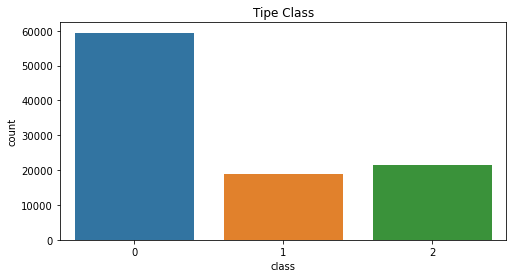

In [13]:
# Kita gunakan barchart

plt.figure(figsize=(8, 4))
sns.countplot(x='class',data=gl)
plt.title('Tipe Class')
plt.show()

Selanjutnya, coba kita lihat data-data yang numerik.

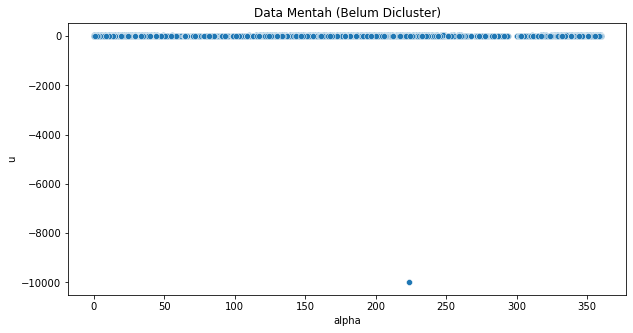

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.scatterplot(
  x=gl['alpha'],
  y=gl['u'],
)
plt.title('Data Mentah (Belum Dicluster)')
plt.show()

Data diatas didapatkan dari penampakan awal bentuk data kita. Oleh karena terdapat satu outlier yang tidak terlalu menganggu bentuk data, maka saya mencoba menghilangkan outlier tersebut agar kita bisa melihat distribusi data dengan baik.

In [15]:
# 13. code here

gl[gl['u'] < -1000]

,alpha,u,class
79543,224.006526,-9999.0,2


In [16]:
# 11. code here

gl = gl[(gl.u != -9999.0)]
gl

,alpha,u,class
0,135.689107,23.87882,0
1,144.826101,24.77759,0
2,142.188790,25.26307,0
3,338.741038,22.13682,0
4,345.282593,19.43718,0
...,...,...,...
99995,39.620709,22.16759,0
99996,29.493819,22.69118,0
99997,224.587407,21.16916,0
99998,212.268621,25.35039,0


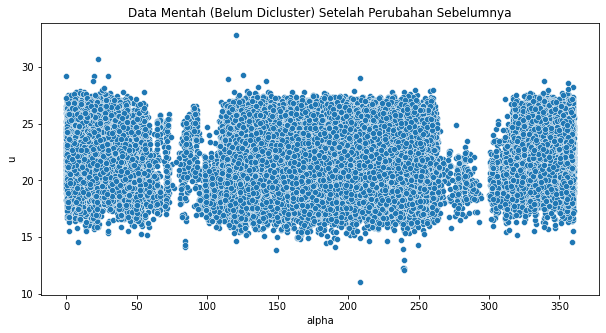

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.scatterplot(
  x=gl['alpha'],
  y=gl['u'],
)
plt.title('Data Mentah (Belum Dicluster) Setelah Perubahan Sebelumnya')
plt.show()

Sebelumnya, kita pecah data menjadi dua. Yaitu **fitur numeric dan fitur classification.** Kita buat terlebih dahulu variabel independen.

In [18]:
# Variabel independen kita adalah seluruh baris dengan kolom alpha dan u
num_feats=gl.iloc[:,0:2]
num_feats.head(3)

,alpha,u
0,135.689107,23.87882
1,144.826101,24.77759
2,142.188790,25.26307


Kemudian, kita buat variabel dependen.

In [19]:
# variabel dependen kita adalah seluruh baris dengan kolom class
gl['class'].unique()

[0, 1, 2]
Categories (3, int64): [0, 1, 2]

In [20]:
cat_feats=gl.iloc[0:,2]
cat_feats

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: class, Length: 99999, dtype: category
Categories (3, int64): [0, 1, 2]

In [21]:
# Kita lihat saja secara sekilas dengan describe
num_feats.describe()

,alpha,u
count,99999.000000,99999.000000
mean,177.628653,22.080679
std,96.502612,2.251068
min,0.005528,10.996230
25%,127.517698,20.352410
50%,180.900527,22.179140
75%,233.895005,23.687480
max,359.999810,32.781390


Coba kita cek distribusi tiap-tiap kolom ini.

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,0.000353,1217.71711,-1.946255e+06,inf,0.071141,0.0


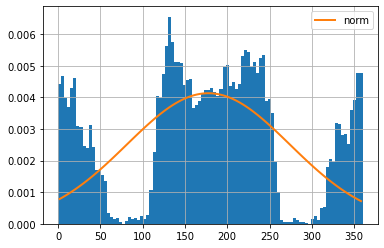

In [22]:
test = Fitter(gl['alpha'], distributions = ['norm'])
test.fit()
test.summary()

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,0.012265,1131.205913,-1.591351e+06,inf,0.029124,4.014655e-74


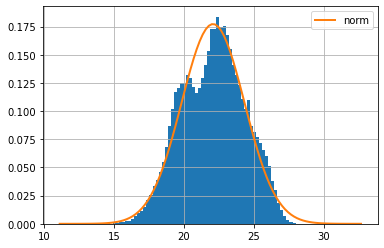

In [23]:
test = Fitter(gl['u'], distributions = ['norm'])
test.fit()
test.summary()

### **EDA Conclusion**

- Terdapat 3 bagian dari kolom class, yaitu GALAXY(59445), QSO(21594), dan STAR(18960). 
- Semua data numerik terdistribusi normal, kecuali alpha.

> Data pada dataset sudah bersih dah siap untuk dilakukan pemodelan

Setelah itu, lakukan modelling clustering dengan K-Means dan DBScan.

# Modeling

Biar lebih memudahkan kita untuk melihat perubahan data pada dataframe kita, kita buat duplikatnya untuk setiap model

In [24]:
gl_km = gl # untuk model K-Means
gl_db = gl # untuk DBScan
gl_compare = gl # untuk pembanding

In [25]:
gl_km

,alpha,u,class
0,135.689107,23.87882,0
1,144.826101,24.77759,0
2,142.188790,25.26307,0
3,338.741038,22.13682,0
4,345.282593,19.43718,0
...,...,...,...
99995,39.620709,22.16759,0
99996,29.493819,22.69118,0
99997,224.587407,21.16916,0
99998,212.268621,25.35039,0


In [26]:
gl_db

,alpha,u,class
0,135.689107,23.87882,0
1,144.826101,24.77759,0
2,142.188790,25.26307,0
3,338.741038,22.13682,0
4,345.282593,19.43718,0
...,...,...,...
99995,39.620709,22.16759,0
99996,29.493819,22.69118,0
99997,224.587407,21.16916,0
99998,212.268621,25.35039,0


In [27]:
gl_compare

,alpha,u,class
0,135.689107,23.87882,0
1,144.826101,24.77759,0
2,142.188790,25.26307,0
3,338.741038,22.13682,0
4,345.282593,19.43718,0
...,...,...,...
99995,39.620709,22.16759,0
99996,29.493819,22.69118,0
99997,224.587407,21.16916,0
99998,212.268621,25.35039,0


## **1. CLUSTERING K-Means**

In [28]:
# Import library yang diperlukan

# Baca Dataset

# Lakukan Clustering

Jangan lupa untuk menampilkan hasil clustering.

In [29]:
# Tampilkan hasil K-Means dengan grafik

### **- Elbow Method**

Import K-Means dan tentukan nilai `K` yang optimal menggunakan metode Elbow dengan membuat *list* inersia/*clusters*.

**Inersia bermakna total jarak antar data dan centroid/pusat yang kita pilih. Semakin kecil, maka semakin data dengan centroid.**

In [30]:
from sklearn.cluster import KMeans

clusters = []
for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(gl_km)
    clusters.append(km.inertia_)

Setelah kita cek bagaimana nilai inertia untuk beberapa jumlah cluster, kita akan taruh ke grafik agar lebih mudah dipahami.

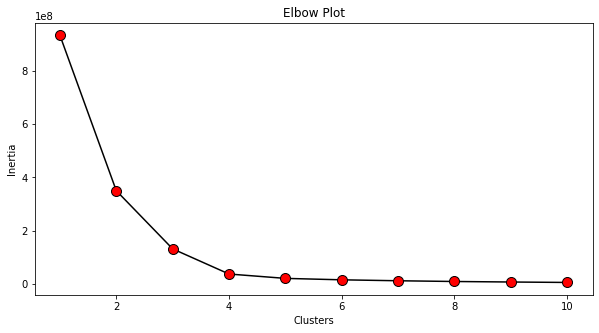

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(list(range(1, 11)), clusters, marker = ".", c= 'black', 
         markerfacecolor = 'red', markersize = 20)
ax.set_title('Elbow Plot')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

plt.show()

Berdasarkan plot/grafik Elbow di atas, Elbow berada di `K = 3` karena penurunan inersia tidak signifikan lagi setelah `K` bernilai 3

### **- Latih K-Means dengan Nilai K Berdasarkan *Elbow Plot***

Sekarang, kita buat model menggunakan 5 cluster. Ingat, bahwa **K-Means merupakan algoritma unsupervised learning**. Yang ia lakukan bukanlah mempelajari sebuah data yang sudah ada, dan memprediksi label untuk data baru.

**Algoritma Unsupervised Learning mengambil sebuah data yang sudah kita miliki, dan mencari sebuah struktur didalamnya.**

K-Means adalah algoritma clustering, **jadi yang K-Means lakukan adalah mencari struktur atau jumlah *cluster*/kelompok yang ada dari data kita.**

In [32]:
# Kita latih model untuk mencari pola dalam data kita
# kita sebutkan bahwa kita menggunakan 5 cluster
km3 = KMeans(n_clusters=3).fit(gl_km)

# Menambahkan kolom label pada dataset
# atau dengan kata lain, kita menaruh label yang telah diberikan algoritma
# kedalam dataset kita
gl['Labels'] = km3.labels_

In [33]:
gl_km

,alpha,u,class,Labels
0,135.689107,23.87882,0,2
1,144.826101,24.77759,0,2
2,142.188790,25.26307,0,2
3,338.741038,22.13682,0,0
4,345.282593,19.43718,0,0
...,...,...,...,...
99995,39.620709,22.16759,0,1
99996,29.493819,22.69118,0,1
99997,224.587407,21.16916,0,2
99998,212.268621,25.35039,0,2


Sekarang, kita visualisasikan.

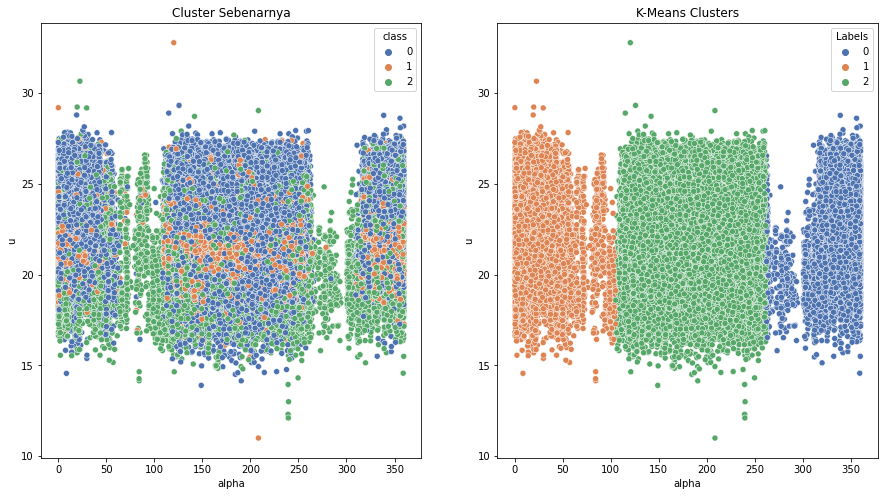

In [34]:
# Kita akan bentuk dua scatter plot
# satu berisi cluster dari data
# satu berisi cluster dari algoritma

# Kita buat sebuah figur dengan ukuran 15 x 8 inci
fig = plt.figure(figsize = (15,8))

# Kita buat 2 bagian, 1 baris 2 kolom pada figur
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Kita taruh scatterplot pada 2 bagian figur tadi
sns.scatterplot(data = gl_km, x = gl_km['alpha'], y = gl_km['u'], ax = ax1, hue = 'class', 
                palette = 'deep')
sns.scatterplot(data = gl_km, x = gl_km['alpha'], y = gl_km['u'], ax = ax2, hue = 'Labels',
                palette = 'deep')

# Kita ubah judul dan label grafik
ax1.set_title('Cluster Sebenarnya')
ax1.set_xlabel('alpha')
ax1.set_ylabel('u')

ax2.set_title('K-Means Clusters')
ax2.set_xlabel('alpha')
ax2.set_ylabel('u')

plt.show()

**NOTE** <br>
['GALAXY', 'QSO', 'STAR'], [0, 1, 2]

Sehingga diperoleh visualisasi dari data ***Galaxy_2 segmentation*** dengan **3
*cluster*** dengan menggunakan algoritma K-Means dan metode Elbow. K-Means mencari struktur dalam data kita, dengan mengelompokkan data kita menjadi kelompok-kelompok atau *cluster*. Disini, kita memberitahunya untuk mengelompokkan data menjadi 3 *cluster*.

### **Kesimpulan K-Means Clustering**

Dari hasil uji coba yang kita lakukan dengan 3 segmen atau *cluster* customer, yaitu:
-   **Cluster pertama (GALAXY)**, yaitu kelompok dengan nilai alpha diantara 0 sampai 100 dan nilai u diantara 13 sampai 33.
-   **Cluster kedua (QSO)**, yaitu kelompok dengan nilai alpha diantara diatas 10 sampai 260 dan nilai u diantara 11 sampai 35.
-   **Cluster ketiga (STAR)**, yaitu kelompok dengan nilai alpha diantara diatas 250 sampai 350 dan nilai u diantara 15 dan 30.

Selain itu, pengklasteran berdasarkan bentuk dari struktur data dengan menggunakan model K-Means terlihat berbeda dengan data sebenarnya.

## **2. CLUSTERING DBScan**

Buatlah model naive bayes disini. Gunakan dataset yang dipakai di KNN sebelumnya.

In [35]:
# Import library yang diperlukan

# Baca Dataset

# Lakukan Clustering

Sekarang, coba lihat hasil clustering DBScan.

In [36]:
# Tampilkan hasil DBScan dengan grafik

### **1. Mengatur Min_samples**

Semakin besar data kita, maka sebaiknya min_samples semakin besar. Aturan yang bisa kalian gunakan adalah menggunakan min_samples yang sama dengan 2 kali dimensi data kalian. Kita punya 2 dimensi data, Alpha dan U, jadi kita menggunakan 4 untuk Min_samples.

### **2. Mengatur Epsilon**

Epsilon bergantung kepada jarak antar anggota cluster. Algoritma apa yang melihat jarak antar titik? Tetangga Terdekat, atau nearest neighbors. Maka, kita akan menggunakan nearest neighbors, mirip seperti KNN, untuk melihat jarak antara suatu titik dengan jumlah tetangganya. Disini, kita akan gunakan 3 tetangga.

In [37]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=3)
neighbors_classified = neighbors.fit(gl_db)

# Kembalian dari kneighbors adalah jarak antara 2 titik terdekat,
# dan pasangan titik terdekat
distances, indices = neighbors_classified.kneighbors(gl_db)

# Jangan lupa untuk diurutkan terlebih dahulu
distances = np.sort(distances, axis=0)
# Kita akan ambil hanya nilai jarak
distances = distances[:, 1]

# Kita cek
distances

array([0.00000000e+00, 0.00000000e+00, 5.73034903e-05, ...,
       3.17663165e+00, 4.06593163e+00, 5.27799065e+00])

Agar lebih mudah, mari kita buat grafik.

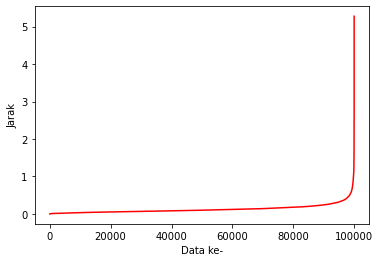

In [38]:
plt.plot(distances, color='red')
plt.xlabel('Data ke-')
plt.ylabel('Jarak')
plt.show()

Perhatikan bagian grafik dimana terbentuk sebuah siku. Itulah nilai epsilon yang baik.

Kita jalankan clustering dengan membuat objek DBScan, dan memberikan 2 parameter, yaitu **epsilon** dan **minimum samples**.

Epsilon adalah radius dari sebuah titik yang akan digunakan algoritma untuk mengelompokkan titik data. Titik yang terkena radius akan menjadi bagian dari sebuah cluster.

Minimum samples akan digunakan sebagai ambang batas, berapa minimal anggota sebuah cluster.

In [39]:
# Panggil objek algoritma dan masukkan data kita
db = DBSCAN(eps=2.9, min_samples=4).fit(gl_db[['alpha', 'u']])

Lalu, kita ambil hasil clustering algoritma.

In [40]:
# db.labels_ adalah properti objek DBScan yang mengandung hasil clustering
Y_Clustered = db.labels_

Kemudian, kita masukkan ke tabel untuk bandingkan dengan yang kita tahu sudah benar.

In [41]:
# Kita masukkan kedalam kolom
gl_db.loc[:, 'Y_Clustered'] = Y_Clustered

# Lalu panggil tabel
gl_db.head()

,alpha,u,class,Labels,Y_Clustered
0,135.689107,23.87882,0,2,0
1,144.826101,24.77759,0,2,0
2,142.188790,25.26307,0,2,0
3,338.741038,22.13682,0,0,1
4,345.282593,19.43718,0,0,1


Anda mungkin merasa wow, besar sekali perbedaannya. Tapi ingat, hasil clustering ini hanya label. Sekarang, kita akan lihat menggunakan grafik, bagaimana perbedaan antara data kita diawal, dan data hasil clustering.

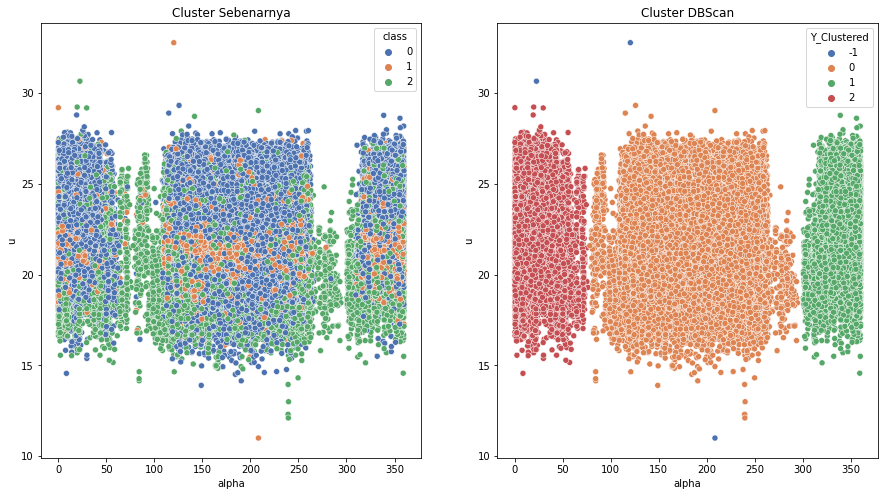

In [42]:
# Kita akan bentuk dua scatter plot
# satu berisi cluster dari data
# satu berisi cluster dari algoritma

# Kita buat sebuah figur dengan ukuran 15 x 8 inci
fig = plt.figure(figsize = (15,8))

# Kita buat 2 bagian, 1 baris 2 kolom pada figur
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Kita taruh scatterplot pada 2 bagian figur tadi
sns.scatterplot(data = gl_db, x = 'alpha', y = 'u', ax = ax1, hue = 'class', 
                palette = 'deep')
sns.scatterplot(data = gl_db, x = 'alpha', y = 'u', ax = ax2, hue = 'Y_Clustered',
                palette = 'deep')

# Kita ubah judul dan label grafik
ax1.set_title('Cluster Sebenarnya')
ax1.set_xlabel('alpha')
ax1.set_ylabel('u')

ax2.set_title('Cluster DBScan')
ax2.set_xlabel('alpha')
ax2.set_ylabel('u')

plt.show()

Nah, jika kalian lihat, dikanan seperti ada 4 cluster, dengan sebuah cluster -1 yang sepertinya mengelilingi cluster lain. **Ini bukanlah cluster baru, tapi OUTLIER.** Jadi, jumlah cluster yang ditemukan oleh DBScan juga 3. **Ini juga salah satu keuntungan DBScan, ia dapat menemukan outlier.**

### **3. Evaluasi**

Ada dua pengukuran untuk mengevaluasi hasil Clustering DBSCan, yaitu **Silhouette Score dan Adjusted Rand Index**.

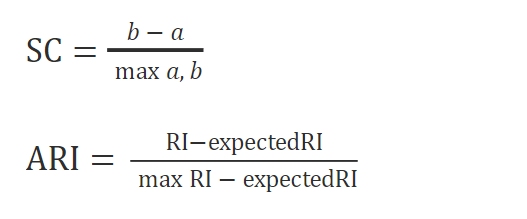

In [43]:
# Skor Silhouette
sc = metrics.silhouette_score(num_feats, db.labels_)
print("Silhouette Coefficient: %0.2f" %sc)

# Rand Index
ari = adjusted_rand_score(cat_feats, db.labels_)
print("Adjusted Rand Index: %0.2f" %ari)

Silhouette Coefficient: 0.53
Adjusted Rand Index: 0.01


Bisa dilihat nilai dari Silihouette Score kita 0.53 yang artinya cluster pada dataset kita cukup ideal **(umumnya ideal SC > 0.5)** . Selain itu, nilai dari ARI juga menunjukkan bahwa data pada tiap klaster kita mirip dengan satu sama lain sehingga sulit untuk membentuk sebuah pola pada dataset kita.

## **3. BANDINGKAN!**

Jangan lupa. Bandingkan hasil kedua clustering. Apa yang bisa anda lihat dari hasil keduanya? Bagaimana anda menginterpretasi hasilnya?

In [44]:
# kita sebutkan bahwa kita menggunakan 3 cluster
km5 = KMeans(n_clusters=3).fit(gl_compare)

# Menambahkan kolom label KMeans
gl_compare.loc[:,'KMeans'] = km5.labels_

Lalu, kita coba dengan DBScan.

In [45]:
# Kita gunakan parameter yang sama
db = DBSCAN(eps=2.9, min_samples=4).fit(gl_compare)

# Kita tambahkan kolom label DBScan
gl_compare.loc[:,'DBScan'] = db.labels_

Cek tabel.

In [46]:
gl_compare.head()

,alpha,u,class,Labels,Y_Clustered,KMeans,DBScan
0,135.689107,23.87882,0,2,0,0,0
1,144.826101,24.77759,0,2,0,0,0
2,142.188790,25.26307,0,2,0,0,0
3,338.741038,22.13682,0,0,1,2,1
4,345.282593,19.43718,0,0,1,2,1


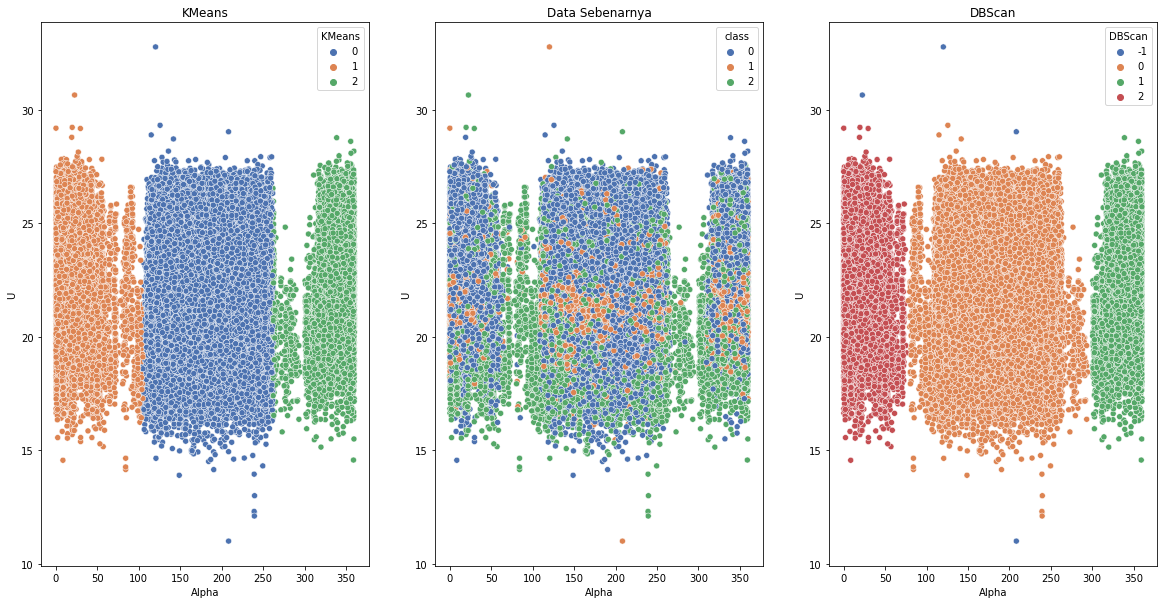

In [47]:
# Kita akan bentuk dua scatter plot
# satu berisi cluster dari data
# satu berisi cluster dari algoritma

# Kita buat sebuah figur dengan ukuran 20 x 10 inci
fig = plt.figure(figsize=(20,10))

# Kita buat 2 bagian, 1 baris 2 kolom pada figur
ax1 = fig.add_subplot(131) # note. 131 artinya "1x3 grid, 1th subplot" 
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

# Kita taruh scatterplot pada 3 bagian figur tadi
sns.scatterplot(
    data=gl_compare,
    x='alpha',
    y='u', 
    ax=ax1, 
    hue='KMeans', 
    palette='deep'
)

sns.scatterplot(
    data = gl_compare, 
    x = gl['alpha'], 
    y = gl_compare['u'], 
    ax = ax2, 
    hue = 'class', 
    palette = 'deep'
)

sns.scatterplot(
    data=gl_compare,
    x='alpha',
    y='u', 
    ax=ax3, 
    hue='DBScan',
    palette='deep'
)

# Kita ubah judul dan label grafik
ax1.set_title('KMeans')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('U')

ax2.set_title('Data Sebenarnya')
ax2.set_xlabel('Alpha')
ax2.set_ylabel('U')

ax3.set_title('DBScan')
ax3.set_xlabel('Alpha')
ax3.set_ylabel('U')

plt.show()

## **4. Kesimpulan**

Setelah kita lihat, perbandingan K-Means dan DBScan tidak terlihat jauh berbeda, hanya saja DBScan dapat mendefenisikan sebuah outlier pada datanya. Namun, dalam pengelompokkan untuk datanya masih kurang sesuai dengan data sebenarnya pada tipe class.

> Dengan K-Means (n_clusters = 3), ditemukan segmen sebanyak 3 cluster, yaitu : 0, 1, dan 2.

> Dengan DBScan (epsilon = 2.9 dan min_sample = 4), ditemukan segmen sebanyak 3 cluster, yaitu : 0, 1, 2 dan sebuah outlier.